Update the clustering Process

* Before
    * Using Bert embeddings to do the clustering

* Now
    * Use TF-IDF vectors to perform clustering
    * Check text cleaning
    * Also Check the cluster pairs that were created and make sure the cluster pairs make sense

In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
import pandas as pd
# pd.set_option('display.max_rows', 10)
# pd.set_option('display.width', 10000)
pd.set_option('display.max_colwidth', None)

import numpy as np
import warnings
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from IPython.display import display, HTML
from collections import defaultdict
import torch
from tqdm import tqdm
import pickle
import h5py
import random
from nltk import word_tokenize

In [3]:
random.seed(42)

In [4]:
from Scripts.utils.general_utils import timer

from Scripts.utils.config import RANDOM_SEED

from Scripts.utils.preprocess_utils import preprocess_texts, tfidf_vectorization, dimensionality_reduction

from Scripts.utils.clustering_utils import run_clustering, get_cluster_sizes, score_cluster, get_cluster_pairs, get_pairwise_dist, cluster2doc, filter_clusters, get_top_100_clusterpairs

from Scripts.utils.data_utils import load_data

from Scripts.utils.plotters_baseline import plot_size_dist

from Scripts.utils.bert_utils import load_model, load_tokenizer, batch_text_gen

from attm_utils import load_pickle

....... Initializing Settings ..... 
Random_Seed Chosen : 15112


In [5]:
path = "../articles.csv"

main_df = load_data(path)

Index(['article_id', 'url', 'title', 'text', 'source', 'source_partisan_score',
       'tweet_id', 'tweet_screen_name', 'tweet_created_at', 'tweet_text'],
      dtype='object')
Df original shape : (921037, 10)
Df shape after dropping nan text : (919430, 10)
Df shape after dropping duplicate articles based on title : (912084, 10)
Df shape after dropping 0 stance articles : (630425, 10)

Finished running 'load_data' in 0.4584 mins



In [29]:
path = "../sampled_articles_from_relevant_data.csv"

rel_df = load_data(path)

Index(['title', 'text', 'source_partisan_score', 'binary_ps', 'processed_text',
       'all_text'],
      dtype='object')
Df original shape : (100000, 6)
Df shape after dropping nan text : (100000, 6)
Df shape after dropping duplicate articles based on title : (99403, 6)
Df shape after dropping 0 stance articles : (99403, 6)

Finished running 'load_data' in 0.0650 mins



In [7]:
path = "../sampled_articles_from_relevant_data_extreme.csv"

rel_extreme_df = load_data(path)

Index(['title', 'text', 'source', 'source_partisan_score', 'binary_ps',
       'processed_text'],
      dtype='object')
Df original shape : (37306, 6)
Df shape after dropping nan text : (37306, 6)
Df shape after dropping duplicate articles based on title : (37298, 6)
Df shape after dropping 0 stance articles : (37298, 6)

Finished running 'load_data' in 0.0225 mins



In [5]:
def get_df(path,extreme=False):
    """
    """
    rel_df = load_data(path)
    
    if extreme:
        rel_df = rel_df.loc[rel_df["source_partisan_score"] != -1 ]
        rel_df = rel_df.loc[rel_df["source_partisan_score"] != 1 ]
    
    rel_df["processed_title"] = preprocess_texts(text_lists=rel_df["title"])
    rel_df["all_text"] = rel_df["processed_title"] + " " +rel_df["processed_text"]
    
    print("Binary Partisan Distribution :\n%s"%str(rel_df["binary_ps"].value_counts().tolist()))
    
    rel_df["Num_Tokens"] = rel_df["all_text"].apply(lambda x: len(x.split(" ")))
    print("Avg Number of Tokens in Articles : %s"%str(rel_df["Num_Tokens"].mean()))
    print("Max Number of Tokens in Articles : %s"%str(rel_df["Num_Tokens"].max()))
    print("Min Number of Tokens in Articles : %s"%str(rel_df["Num_Tokens"].min()))
    
    print("Num Tokens Dist :\n")
    rel_df["Num_Tokens"].plot(kind="hist")
    
    return rel_df

In [6]:


def cluster_articles(df,num_clusters):
    """
    """
    vectors,vocab,tfidf_vectorizer = tfidf_vectorization(df=df,min_df=50,max_df=0.75,seed=RANDOM_SEED,max_features=20000,combine_text=False)
    clusters,cluster_clf = run_clustering(vectors=vectors,seed=RANDOM_SEED,num_clusters=num_clusters,clus_type="kmeans")
    cluster_sizes = get_cluster_sizes(cluster_clf)
    plot_size_dist(cluster_sizes)
    
    return clusters, cluster_clf,cluster_sizes

def map_art_2_clus(df,cluster_clf):
    """
    """
    doc_2_cluster_map = cluster2doc(num_texts=df.shape[0],cluster_labels=cluster_clf.labels_)
    return doc_2_cluster_map

def filter_clusters_size(cluster_sizes,min_size=300,max_size=3000):
    """
    """
    filtered_clusters = []
    for cluster in cluster_sizes.keys():
        if cluster_sizes[cluster] >= min_size and cluster_sizes[cluster] <= max_size:
            filtered_clusters.append(cluster)
    return filtered_clusters

def filter_by_partisan_dist(clusters,cluster_2_doc_map,df,partisan_dist_diff=0.20):
    """
    """
    filtered_clusters = []
    for c in tqdm(clusters,total=len(clusters)):
        c_docs_indices = cluster_2_doc_map[c]
        total_size = len(c_docs_indices)
        c_df = df["binary_ps"].iloc[c_docs_indices]
        ps_dist = c_df.value_counts().tolist()
        pos_dist = ps_dist[-1]/total_size
        neg_dist = ps_dist[0]/total_size
        dist_diff = np.abs(pos_dist - neg_dist)
        
        if dist_diff <= partisan_dist_diff:
            filtered_clusters.append(c)
    
    return filtered_clusters

def filter_clusters(df,cluster_sizes,doc_2_cluster_map):
    """
    """
    fil_clusters = filter_clusters_size(cluster_sizes,min_size=300,max_size=3000)
    fil_ps_clusters = filter_by_partisan_dist(clusters=fil_clusters,
                                          cluster_2_doc_map=doc_2_cluster_map,
                                          df=df,
                                          partisan_dist_diff=0.30)
    return fil_ps_clusters

def create_cluster_pairs(clusters):
    cluster_pairs = []
    for pair in itertools.combinations(clusters,2):
        
        cluster_pairs.append(pair)
    
    return cluster_pairs

def select_top_n_similar_cps(cps,cluster_clf,n=10):
    """
    """
    dist_matrix = cosine_similarity(cluster_clf.cluster_centers_)
    sorted_cps = sorted(cps,key=lambda x: dist_matrix[x[0],x[1]],reverse=True)[:n]
    return sorted_cps

def select_top_cluster_with_keywords(df,clusters,doc_2_cluster_map,keywords=["democrat","republican"]):
    """
    """
    cluster_scores = {}
    for c in tqdm(clusters,total=len(clusters)):
        c_docs = df["all_text"].iloc[doc_2_cluster_map[c]].tolist()
        keyword_doc_counts = defaultdict(int)
        for doc in c_docs:
            for k in keywords:
                if k in doc:
                    keyword_doc_counts[k]+=1
        cluster_scores[c] = sum([keyword_doc_counts[k] for k in keywords])/len(c_docs)
    
    cluster_score_tuples = sorted(list(cluster_scores.items()),key=lambda x:x[1],reverse=True)
    return cluster_score_tuples

In [7]:
def vectorize_text(text_list):
    """
    """
    tfidf_vectorizer = TfidfVectorizer(min_df=30, binary=False, max_df=0.90, stop_words='english',max_features=None)
    tf_idf_vectors = tfidf_vectorizer.fit_transform(text_list)
    print("Vocab Size : %s "%str(len(tfidf_vectorizer.get_feature_names())))
    return tf_idf_vectors, tfidf_vectorizer

def get_tokens(text_list,batch_size=100,max_length=15):
    tokenizer = load_tokenizer()
    all_toks = []
    for batch_num,batched_text in enumerate(tqdm(batch_text_gen(text_list,batch_size=batch_size),total=int(len(text_list)/batch_size)+1)):
        encoded_batch = tokenizer.batch_encode_plus(batched_text, add_special_tokens=True, max_length = max_length, padding='max_length', return_attention_mask = False,truncation=True, return_tensors = 'pt')
        token_tensors = encoded_batch["input_ids"] # 2d , (batch_size,max_length)
        batched_toks = []
        for sent in range(token_tensors.size()[0]):
            sent_toks = []
            tokens = tokenizer.convert_ids_to_tokens(token_tensors[sent])
            for t in tokens:
                if t not in ['[SEP]', '[PAD]']:
                    sent_toks.append(t)
            batched_toks.append(sent_toks)
        
        all_toks += batched_toks
    
    return all_toks

def sample_pos_context_word(tokens,tfidf_vec,tf_idf_vectorizer,search_range=20,sample_size=2):
    """
    """
    sampled_words = []
    tokenslc = [t.lower() for t in tokens]
    # high tfidf terms in text argsort descending
    sorted_indices = np.argsort(tfidf_vec.todense())[::-1].tolist()[0]
    sorted_tokens_tfidf = np.array(tf_idf_vectorizer.get_feature_names())[sorted_indices]
    # bert tokens of text
    for tftoken in sorted_tokens_tfidf.tolist():
        if tftoken in tokenslc:
            sampled_words.append(tftoken)

        if len(sampled_words) == sample_size:
            break
    return sampled_words

def sample_neg_context_word(tokens,pos_words_set,sample_size=2):
    """
    """
    tokenslc = [t.lower() for t in tokens]
    sampled_words = []
    hard_stop = 0
    while True:
        sw = random.choice(pos_words_set)
        hard_stop +=1
        if sw not in tokenslc:
            sampled_words.append(sw)
        
        if len(sampled_words) == sample_size:
            break
        
        if hard_stop == 20:
            break
        
    return sampled_words
            

def sample_context_words(df,tfidf_vecs,all_tokens,tf_idf_vectorizer,sample_size=3,search_range=20):
    """
    """
    sampled_pos = []
    all_pos = []
    sampled_neg = []
    for i in tqdm(range(df.shape[0]),total=df.shape[0]):
        
        sample_pos = sample_pos_context_word(tokens=all_tokens[i],
                                             tfidf_vec=tfidf_vecs[i],
                                             tf_idf_vectorizer=tf_idf_vectorizer,
                                             search_range=search_range,
                                             sample_size=sample_size)
    
        sampled_pos.append(sample_pos)
        all_pos = all_pos + sample_pos
    
    sampled_pos_unique = list(set(all_pos))
    
    print("Pos tokens size : %s"%str(len(all_pos)))
    print("Pos vocab size : %s"%str(len(sampled_pos_unique)))
    
    for i in tqdm(range(df.shape[0]),total=df.shape[0]):
        
        sample_neg = sample_neg_context_word(tokens=all_tokens[i],
                                             pos_words_set=sampled_pos_unique,
                                             sample_size=sample_size)
        
        sampled_neg.append(sample_neg)
    
    unsampled_pos = 0
    unsampled_neg = 0
    
    for i in tqdm(range(df.shape[0]),total=df.shape[0]):
        
        if len(sampled_pos[i]) < sample_size:
            unsampled_pos +=1
        
        if len(sampled_neg[i]) < sample_size:
            unsampled_neg +=1
    
    print("Articles missing a pos context word : %s"%str(unsampled_pos))
    print("Articles missing a neg context word : %s"%str(unsampled_neg))
    
    return sampled_pos, sampled_neg
    
        

In [8]:
def save_obj(path,obj):
    """
    """
    with open(path,"wb") as wb:
        pickle.dump(obj,wb)


def prepare_data(path,num_clusters=100,min_c_size=300,max_c_size=3000,partisan_dist_diff=0.3,extreme=False,return_data=True):
    """
    """
    print("********* 1. Loading Data **************")
    rel_df = get_df(path,extreme=extreme)
    
    rel_df = rel_df.reset_index(drop=True)
    
    print("***************** 2. Sampling Context Words *****************")
    tf_idf_vectors, tfidf_vectorizer = vectorize_text(text_list=rel_df["processed_title"])
    
    all_tokens = get_tokens(text_list=rel_df["processed_title"],batch_size=100,max_length=15)
    
    sampled_pos, sampled_neg = sample_context_words(df=rel_df,
                                                    tfidf_vecs=tf_idf_vectors,
                                                    all_tokens=all_tokens,
                                                    tf_idf_vectorizer=tfidf_vectorizer,
                                                    sample_size=2,
                                                    search_range=20)
    
    rel_df["context_pos_words"] = sampled_pos
    rel_df["context_neg_words"] = sampled_neg
    
    rel_df["context_pos_word_len"] = rel_df["context_pos_words"].apply(lambda x: len(x))
    
    print("Before Dropping Samples due to missing context_pos_words : %s" %str(rel_df.shape))
    
    rel_df = rel_df.loc[rel_df["context_pos_word_len"]>=1]
    
    print("After Dropping Samples due to missing context_pos_words : %s" %str(rel_df.shape))
    
    rel_df = rel_df.reset_index(drop=True)
    
    
    if extreme:
        save_obj(path="Data_4_AttM/rel_df_extreme.pkl",obj=rel_df)
    
    if not extreme:
        save_obj(path="Data_4_AttM/rel_df.pkl",obj=rel_df)
    
    
    
    print("*********** 3. Clustering Articles ************")
    clusters, cluster_clf,cluster_sizes = cluster_articles(df=rel_df,num_clusters=num_clusters)
    
    print("********** 4. Creating Doc 2 cluster Map ************")
    doc_2_cluster_map = map_art_2_clus(df=rel_df,cluster_clf=cluster_clf)
    
    if extreme:
        save_obj(path="Data_4_AttM/doc_2_cluster_map_extreme.pkl",obj=doc_2_cluster_map)
    
    if not extreme:
        save_obj(path="Data_4_AttM/doc_2_cluster_map.pkl",obj=doc_2_cluster_map)
    
    print("*********** 5. Filtering Clusters ****************")
    
    filtered_clusters = filter_clusters_size(cluster_sizes=cluster_sizes,min_size=min_c_size,max_size=max_c_size)
    
    filtered_clusters = filter_by_partisan_dist(filtered_clusters,doc_2_cluster_map,df=rel_df,partisan_dist_diff=partisan_dist_diff)
    
    print("Number of Filtered Clusters : %s"%str(len(filtered_clusters)))
    
    print("*********** 6. Scoring Clusters based on Keyword Precsence *************")
    cluster_score_tuples = select_top_cluster_with_keywords(df=rel_df,
                                                            clusters=filtered_clusters,
                                                            doc_2_cluster_map=doc_2_cluster_map,
                                                            keywords=["democrat","republican"])
    
    if extreme:
        save_obj(path="Data_4_AttM/cp_scored_extreme.pkl",obj=cluster_score_tuples)
    
    if not extreme:
        save_obj(path="Data_4_AttM/cp_scored.pkl",obj=cluster_score_tuples)
    
    if return_data:
        
        return doc_2_cluster_map, cluster_score_tuples, rel_df
    

In [9]:
def analyze_cp(cps,df,cluster_2_doc_map):
    """
    """
    for cp in cps:
        print("\n******* %s ***********\n"%str(cp))
        c1_df = df.iloc[cluster_2_doc_map[cp[0]]]
        display(c1_df[["title","text"]].head(5))
        

def save_bert_embeddings(df,save_path="/media/karthikshivaram/SABER_4TB/attm_bert_embeddings/token_bert_12_embeds_attm.hdf5",batch_size=100,max_length=350):
    """
    I need to batch infer but save them with original doc indices
    """
    texts = df["all_text"].tolist()
    model = load_model()
    model.to(torch.device('cuda:1'))
    tokenizer = load_tokenizer()
    
    with h5py.File(save_path, "w") as f:
        num_batches = int(df.shape[0]/batch_size)+1
        print("Num Batches : %s"%str(num_batches))
        print("Dataset Shape : %s"%str((num_batches*batch_size,max_length,768)))
        dset = f.create_dataset("bert_embeds",shape=(num_batches*batch_size,max_length,768),dtype="float32")
        start_ind = 0
        with torch.no_grad():
            for batch_num,batched_text in enumerate(tqdm(batch_text_gen(texts,batch_size=batch_size),total=int(df.shape[0]/batch_size)+1)):
                encoded_batch = tokenizer.batch_encode_plus(batched_text, add_special_tokens=True, max_length = max_length, padding='max_length', return_attention_mask = False,truncation=True, return_tensors = 'pt')
                token_tensors = encoded_batch["input_ids"]
                token_tensors = token_tensors.to(torch.device('cuda:1'))
                batch_out = model(token_tensors)
                batch_hidden_states = batch_out[2]
                batch_12_layer_tensor = batch_hidden_states[-1]
                end_ind = start_ind + batch_12_layer_tensor.size()[0]
#                 print("Start index : %s :: End index : %s"%(str(start_ind),str(end_ind)))
#                 print(batch_12_layer_tensor.size()[0])
#                 print(batch_12_layer_tensor.size())
                dset[start_ind:end_ind,:,:] = batch_12_layer_tensor.cpu().numpy()
                start_ind = end_ind
                f.flush()

In [ ]:
def count_words(X):
    XX = X.copy()
    XX.data /= XX.data
    return XX.sum(axis=0).A1 / X.shape[0]

def get_bad_terms(X, df, vocab):
    """
    bad terms correlate with class label across all documents
    and are relatively frequent.
    We fit a simple logistic regression on all documents, 
    find top 100 terms per class, then select 100 most frequent from those.
    """
    clf = LogisticRegression(C=1, random_state=42, max_iter=1000)
    clf.fit(X, df.partisan)
    c = clf.coef_[0]
    bad_terms = []
    feats = np.array(vocab.get_feature_names())
    for i in np.argsort(c)[::-1][:200]:
        bad_terms.append(feats[i])
    for i in np.argsort(c)[:200]:
        bad_terms.append(feats[i])
    bad_terms = set(bad_terms)    
    word_count = count_words(X)
    f = sorted([(word_count[vec.vocabulary_[w]], w)  for w in bad_terms])[::-1][:200]
    return set(i[1] for i in f)

def match_bad_terms(tokens_train, tokens_test, bad_terms):    
    all_toks = set()
    for t in tokens_train:
        all_toks.update(t)
    for t in tokens_test:
        all_toks.update(t)
    return sorted(list(bad_terms & all_toks))

********* 1. Loading Data **************
Index(['title', 'text', 'source_partisan_score', 'binary_ps', 'processed_text',
       'all_text'],
      dtype='object')
Df original shape : (100000, 6)
Df shape after dropping nan text : (100000, 6)
Df shape after dropping duplicate articles based on title : (99403, 6)
Df shape after dropping 0 stance articles : (99403, 6)

Finished running 'load_data' in 0.0649 mins

Running : select_first10
Running : to_lower
Running : remove_punc
Running : remove_small_words
Running : remove_spaces
Running : remove_non_alpha_numeric

Finished running 'preprocess_texts' in 0.0903 mins

Binary Partisan Distribution :
[57905, 41498]
Avg Number of Tokens in Articles : 225.5079122360492
Max Number of Tokens in Articles : 1936
Min Number of Tokens in Articles : 35
Num Tokens Dist :

***************** 2. Sampling Context Words *****************
Vocab Size : 3813 


 25%|██▍       | 24548/99403 [00:00<00:00, 245476.72it/s]

Pos tokens size : 196942
Pos vocab size : 2842


100%|██████████| 99403/99403 [00:00<00:00, 2249230.71it/s]


Articles missing a pos context word : 1632
Articles missing a neg context word : 0
Before Dropping Samples due to missing context_pos_words : (99403, 11)
After Dropping Samples due to missing context_pos_words : (99171, 11)
*********** 3. Clustering Articles ************
vocab_size : 15005

Finished running 'tfidf_vectorization' in 0.1977 mins


Running KMEANS Clustering with k=100

Finished running 'run_clustering' in 0.3900 mins


Finished running 'get_cluster_sizes' in 0.0002 mins



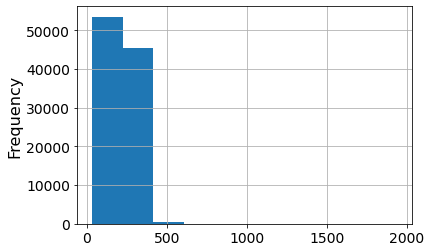

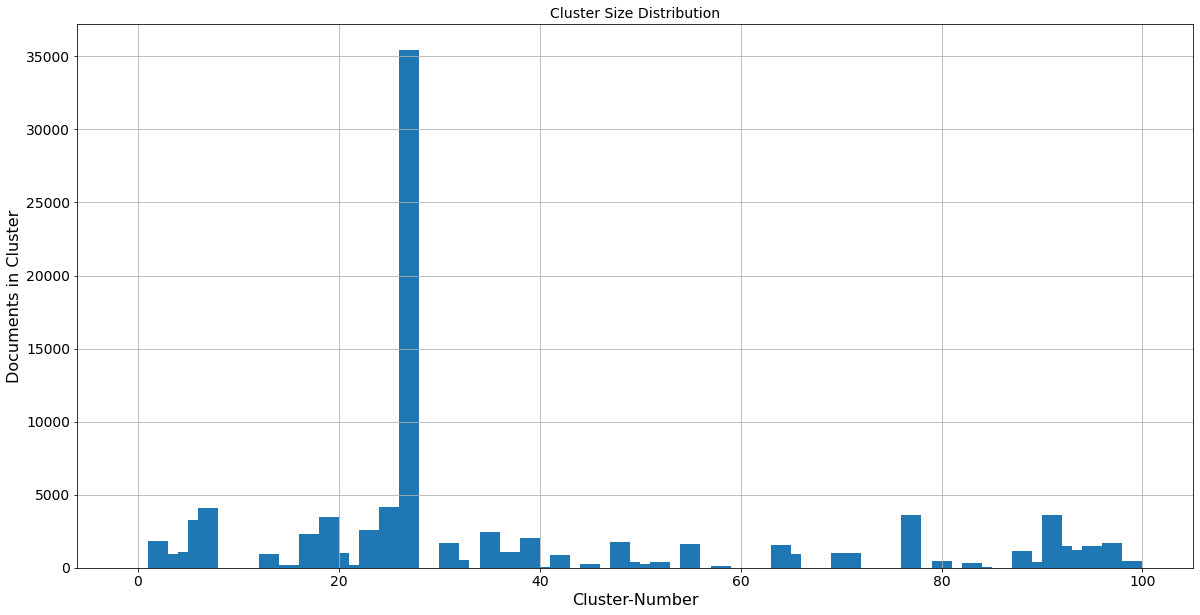

100%|██████████| 28/28 [00:00<00:00, 266.26it/s]

********** 4. Creating Doc 2 cluster Map ************

Finished running 'cluster2doc' in 0.0005 mins

*********** 5. Filtering Clusters ****************
Number of Filtered Clusters : 28
*********** 6. Scoring Clusters based on Keyword Precsence *************


In [28]:
doc_2_cluster_map, cps, rel_df = prepare_data(path="../sampled_articles_from_relevant_data.csv",num_clusters=100,min_c_size=400,max_c_size=4000,partisan_dist_diff=0.4,extreme=False,return_data=True)

In [29]:
cps

[(26, 1.4974271012006861),
 (77, 1.3629343629343629),
 (55, 1.336024844720497),
 (42, 1.1111111111111112),
 (71, 1.0434362934362935),
 (92, 0.9945982444294396),
 (91, 0.9727797635413803),
 (37, 0.96289592760181),
 (20, 0.9254170755642787),
 (39, 0.8945544554455446),
 (23, 0.8905950095969289),
 (5, 0.8847969782813976),
 (70, 0.7678571428571429),
 (99, 0.7650602409638554),
 (31, 0.7517688679245284),
 (95, 0.7073490813648294),
 (2, 0.7017732401934443),
 (64, 0.675744141861938),
 (94, 0.6609336609336609),
 (35, 0.6284062758051198),
 (4, 0.5497267759562842),
 (65, 0.44742268041237115),
 (13, 0.411946446961895),
 (88, 0.3746724890829694),
 (19, 0.34341129492298916),
 (49, 0.3422982885085575),
 (17, 0.2668103448275862),
 (97, 0.23750734861845973)]

In [32]:
analyze_cps(cps=cps,df=rel_df,cluster_2_doc_map=doc_2_cluster_map)


******* (26, 1.4974271012006861) ***********



title  \
48                                     Senate Republicans slam Democrats’ impeachment case as nothing new   
61                       White House wants Senate trial rules to include ability to dismiss Trump charges   
92   Capitol Hill reporters protest expected restrictions on media access during Senate impeachment trial   
229               Trump’s Impeachment Trial Won’t Keep The Chief Justice Away From The State Of The Union   
291                 Some House Democrats push Pelosi to withhold impeachment articles, delay Senate trial   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

Empty DataFrame
Columns: [title, text]
Index: []


******* (77, 1.3629343629343629) ***********



title  \
69   Analysis | The counties with the best — and worst — track records of predicting presidential winners   
81                                                   How Republicans Can Win Over Minority Voters in 2020   
87                                          California Admits DMV Error Added Non-Citizens To Voter Rolls   
222                   Spotlight on Stacey Abrams, voter suppression as Democrats set to debate in Georgia   
234          'Alarm bells should be going off everywhere': Trump losing women voters in the Texas suburbs   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

Empty DataFrame
Columns: [title, text]
Index: []


******* (55, 1.336024844720497) ***********



title  \
151                    Nancy Pelosi's wretched, saccharine speech fits her shoddy impeachment   
264                                 Rob Reiner: Donald Trump 'Defecating on Our Constitution'   
302                                Trump vents over Pelosi impeachment push over Ukraine call   
319           McCarthy Fires Back At Pelosi After Impeachment Calls: ‘Cannot Change The Laws’   
348  Tucker Carlson: Democrats have lost the Trump impeachment war. Even Adam Schiff knows it   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

Empty DataFrame
Columns: [title, text]
Index: []


******* (42, 1.1111111111111112) ***********



title  \
14   Adriana Cohen: Twitter not only politically biased, it's crossed over into election meddling, too   
93                              Coronavirus chaos in Georgia, Wisconsin a 'warning sign' for Democrats   
112                                                  Trump requests mail-in ballot for Florida primary   
600                               Trump Encourages Use of Mail-In Ballots in Florida in Stark Reversal   
641            First Thing: blocked mail and birtherism – Trump's plan to win in 2020 | | The Guardian   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

Empty DataFrame
Columns: [title, text]
Index: []


******* (71, 1.0434362934362935) ***********



title  \
74   As Julián Castro exits the race, Democrats renew concerns over diversity in presidential field   
77                  Bill Maher roasts Democratic presidential field: ‘What’s the emoji for Losers?’   
188               Bloomberg campaign raises eyebrows with a meatball featuring the candidate's face   
371                                     Tom Perez helps drive labor deal, sparing Democratic debate   
467                    Las Vegas Democratic debate live updates: Six candidates faced off in Nevada   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

Empty DataFrame
Columns: [title, text]
Index: []


******* (92, 0.9945982444294396) ***********



title  \
397                                              Who spoke the most during tonight's debate   
432                                                   The Liberal Voters Biden Doesn’t Want   
517  Why Democratic candidates like Buttigieg keep failing to usher in the "Christian left"   
531                                              Two new candidates will not save Democrats   
599                                             Pete Buttigieg Is Not Intersectional Enough   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

Empty DataFrame
Columns: [title, text]
Index: []


******* (91, 0.9727797635413803) ***********



title  \
44                           The truth about Sanders' Cold War comments is too complicated for cable news   
51                                             Opinion | Why the Democratic Establishment Still Has Juice   
96                                              Bernie Sanders: ‘This is not the time for a protest vote’   
142  Some Tea Party Republicans in South Carolina are voting for Bernie Sanders in the Democratic primary   
145                                    As goes Bernie, so go the Democrats, toward nomination or deadlock   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

Empty DataFrame
Columns: [title, text]
Index: []


******* (37, 0.96289592760181) ***********



title  \
206                        'An exercise in obfuscation': Stephen Miller and Chris Wallace spar about Ukraine   
320                                                             Trump Retweets Name of Alleged Whistleblower   
335                    Schiff suggests whistleblower testimony "might not be necessary" in impeachment probe   
403                        White House tried to cover up Trump's Ukraine conversation, whistleblower alleges   
568  Intelligence official directly contradicts Trump administration's excuses for suppressing whistleblower   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              text  
206                                                                                                                              

Empty DataFrame
Columns: [title, text]
Index: []


******* (20, 0.9254170755642787) ***********



title  \
24                                                    Twenty Years After Busing Ended, School Segregation Is Back   
103  Kamala Harris Co-Sponsored Bill That Would Force Schools To Let Male Athletes Compete In Girls&#8217; Sports   
204                                                   5 things Sen. Kamala Harris has done besides be interrupted   
211                           Kamala Harris criminal justice plan calls for government loans to marijuana growers   
276        Kamala Harris Wouldn’t Apologize For Cynical Attack On Biden During Debate, Might Not Be ‘Lock’ For VP   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

Empty DataFrame
Columns: [title, text]
Index: []


******* (39, 0.8945544554455446) ***********



title  \
29                        Trump, abortion and attacks on Warren: the Democratic debate's key takeaways   
130                               Elizabeth Warren proposes a transition phase before Medicare-for-all   
149  Former Secretary of Housing and Urban Development Julián Castro Endorses Senator Elizabeth Warren   
164                Anti-super PAC crusader Elizabeth Warren flips to accept support as race gets tough   
383                    New York Times joint endorsement of Warren, Klobuchar was double-barrel misfire   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

Empty DataFrame
Columns: [title, text]
Index: []


******* (23, 0.8905950095969289) ***********



title  \
7                                     Liz Cheney on Ukraine: 'Starting to Seem Like a Political Setup'   
58                  Trump Asked Zelensky to Work with Giuliani to Investigate Origins of Mueller Probe   
109                                             Trump's authoritarian tendencies come back to bite him   
113  Trump just gave away the game on his bribery scheme in a live interview to baffled Fox News hosts   
153                        Trump’s Ukraine call reveals a president convinced of his own invincibility   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

Empty DataFrame
Columns: [title, text]
Index: []


******* (5, 0.8847969782813976) ***********



title  \
89                                                     Lindsey Graham changes his tune on Joe Biden, urges State document release   
184                                                               Pete Buttigieg: I would not have wanted my son on Ukraine board   
296                                                                    Senate panel postpones subpoena vote in Hunter Biden probe   
352                                    What Joe Biden said to his son Hunter about Ukraine and Burisma shows he knew it was shady   
414  Sen. Ron Johnson denies getting dirt on Biden from Ukrainian lawmaker, blasts Blumenthal for 'twisting' classified briefings   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

Empty DataFrame
Columns: [title, text]
Index: []


******* (70, 0.7678571428571429) ***********



title  \
114  Andrew Yang floats hiking beef prices to 'modify' American diets in bid to address climate change   
144  How a climate skeptic marginalized for years at the Interior Dept. rose to prominence under Trump   
178                     Alexandria Ocasio-Cortez participates in protest outside Nancy Pelosi's office   
180                                                               'Green Dreams' threaten real US jobs   
233                         John Kerry launches coalition to fight climate crisis: ‘We are way behind’   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

Empty DataFrame
Columns: [title, text]
Index: []


******* (99, 0.7650602409638554) ***********



title  \
38   Bolton is the latest in a long line of people Trump has accused of 'begging' him for something   
209                                     Democrats ask John Bolton to testify in impeachment inquiry   
225                           Nadler: Bolton 'likely' to be subpoenaed by House Judiciary Committee   
316           Bolton claims Trump said reporters 'should be executed,' requested DOJ seek jail time   
597                                                   Impeachment probe deepens a Trump team divide   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

Empty DataFrame
Columns: [title, text]
Index: []


******* (31, 0.7517688679245284) ***********



title  \
27                              If You're Trying To Ban Guns, The Least You Can Do Is Learn The Basics   
37                               San Francisco officials brand NRA a ‘domestic terrorist organization’   
42  Analysis | Marco Rubio’s claim that no recent mass shootings would have been prevented by gun laws   
49                               Republicans Blocked A Gun Control Bill During Another School Shooting   
86                                                New Zealand Gun Buyback Was An ‘Unmitigated Failure’   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

Empty DataFrame
Columns: [title, text]
Index: []


******* (95, 0.7073490813648294) ***********



title  \
76                        These are the lawyers on Robert Mueller's special counsel team   
110  Carter Page tells Congress of contact with Russian official during 2016 Moscow trip   
163                        Surveillance bill clears House, but Senate fate remains murky   
224       FBI vets: What many are missing about the infamous 'dossier' amid Russia probe   
439                                 Politicizing Steele’s Raw, Unverified ‘Intelligence’   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

Empty DataFrame
Columns: [title, text]
Index: []


******* (2, 0.7017732401934443) ***********



title  \
31                                                                          The endless hypocrisy of Eric Holder   
40                                        Obama refugee vetting procedure enabled Iraqi terrorists to enter U.S.   
64                 Trump’s Small Biz Rescue Bailed Out Kushner’s Family, Obama’s Aides and Other Political Elite   
104                                               4 Times Michelle Obama Said We Should Make America Great Again   
116  2020 Election Live Updates: Republicans Reject Trump’s Suggestion to Delay Election, Something He Cannot Do   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

Empty DataFrame
Columns: [title, text]
Index: []


******* (64, 0.675744141861938) ***********



title  \
70                                             What you need to do to get your government stimulus check   
127                                        Joe Biden’s tax policy worse for economy than the coronavirus   
132                        Opinion | Yes, our tax system needs reform. Let’s start with this first step.   
133                                                   Trump: My tax plan is 'going to cost me a fortune'   
242  Republicans prove they'll never miss an opportunity to help the top 1% — not even during a pandemic   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

Empty DataFrame
Columns: [title, text]
Index: []


******* (94, 0.6609336609336609) ***********



title  \
60      Betsy DeVos compares anti-abortion activism to fight against slavery   
73                      A Judge Blocked Alabama’s Near-Total Ban On Abortion   
183  Top Democrat: Biden's abortion flip-flop could cost him 2020 nomination   
201          Planned Parenthood sets ‘abortion quotas,’ former employees say   
216    Mississippi’s ban on abortions at 15 weeks gets shut down second time   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

Empty DataFrame
Columns: [title, text]
Index: []


******* (35, 0.6284062758051198) ***********



title  \
4                                               Supreme Court clears way for execution of federal prisoner   
26                                  Supreme Court decisions affect LGBTQ social acceptance, research finds   
82                                    Rene Boucher, Rand Paul attacker, has 30-day prison sentence vacated   
118                                                         Scalia: ‘Limitations’ possible for gun control   
170  Trump's Lawyers Argue Congress Has Little Power To Investigate A Sitting President's Personal Affairs   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

Empty DataFrame
Columns: [title, text]
Index: []


******* (4, 0.5497267759562842) ***********



title  \
17      READ: The government document of meeting between US and military leader of Syrian Kurds   
300                                                 Trump orders all sanctions on Turkey lifted   
336  Iraq contradicts U.S. defense secretary, says U.S. troops leaving Syria can't stay in Iraq   
340          Here's why Turkish bodyguards in bloody D.C. brawl likely won't face repercussions   
341                                  House Democrats to condemn Turkey after Trump’s withdrawal   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

Empty DataFrame
Columns: [title, text]
Index: []


******* (65, 0.44742268041237115) ***********



title  \
1                                                             How the US government created a fake university to snare immigrant students | US immigration | The Guardian   
68                                                                                                     Bernie Sanders’s free college proposal just got a whole lot bigger   
72                                                Black and Brown People Have Been Protesting for Centuries. It's White People Who Are Responsible for What Happens Next.   
95  Analysis | Bill and Melinda Gates have spent billions to drive their agenda on education and other issues. Now, they have created a lobbying group to push even more.   
97                                                  Booker Unveils Plan Targeting ‘Exploitation’ Of College And Professional Athletes As Candidates Focus On LGBTQ Issues   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

Empty DataFrame
Columns: [title, text]
Index: []


******* (13, 0.411946446961895) ***********



title  \
65      White House: Trump's 'second thoughts' on China trade war 'greatly misinterpreted'   
263                               Bernie Sanders Is the Developing World’s Worst Nightmare   
279  Trump announces partial trade deal with China, lifting hopes that tensions could ease   
294     Once Again, China Is Showing Trump That Trade Wars Are Not “Good, and Easy to Win”   
309                              Senate Passes Revised NAFTA, Sending Pact to Trump’s Desk   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

Empty DataFrame
Columns: [title, text]
Index: []


******* (88, 0.3746724890829694) ***********



title  \
100                  China summons US ambassador, says US blocks its development   
107         George H.W. Bush, Barack Obama shared realist view of foreign policy   
135  Expert: Visas for China 'Should Be Last Priority' During Coronavirus Crisis   
213                        Senate Approves Bill Aimed at China’s Currency Policy   
355       How Trump just upped the ante with China over trade deal: expert panel   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

Empty DataFrame
Columns: [title, text]
Index: []


******* (19, 0.34341129492298916) ***********



title  \
3                                                  Trump's draconian border lockdown has a new target   
5   After testy call with Trump over border wall, Mexican president shelves plan to visit White House   
6                             Opinion | If Congress had any pride, it would set an immigration policy   
67                                             Bronx lawmaker Jose Serrano: Make NY a sanctuary state   
98                Coronavirus on the border: California hospitals overwhelmed by patients from Mexico   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

Empty DataFrame
Columns: [title, text]
Index: []


******* (49, 0.3422982885085575) ***********



title  \
212                     Retired General: Drones Create More Terrorists Than They Kill, Iraq War Helped Create ISIS   
255  Comey Told Obama that Flynn’s Conversations with Russian Ambassador ‘Appear Legit,’ According to Strzok Notes   
384                                              After Susan Rice email backfires on right, GOP pretends otherwise   
524                                     Flynn could reprise Trump campaign role, as he fights to clear legal cloud   
528           KT McFarland responds to Flynn documents: FBI's goal 'was to get Trump,' we 'were collateral damage'   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

Empty DataFrame
Columns: [title, text]
Index: []


******* (17, 0.2668103448275862) ***********



title  \
102                        Iranian citizen who violated US sanctions by exporting carbon fiber get prison time   
123         While Iranian students rip down posters of Soleimani, Syria awards him a posthumous medal of honor   
152                                                    Who was the Iranian general killed by a U.S. airstrike?   
172                                                    Iran-Backed Milin Withdraw From U.S. Embassy in Baghdad   
189  Soleimani funeral procession in Baghdad draws thousands of mourners chanting 'America is the Great Satan'   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

Empty DataFrame
Columns: [title, text]
Index: []


******* (97, 0.23750734861845973) ***********



title  \
9                                 Pompeo recalls Afghan peace envoy after Trump cancels Camp David Taliban meeting   
25                                            NY Times criticized for publishing op-ed by deputy leader of Taliban   
90   THREATS AND RESPONSES: THE VOTE; CONGRESS AUTHORIZES BUSH TO USE FORCE AGAINST IRAQ, CREATING A BROAD MANDATE   
158                       Donald Trump dismisses injuries of US military troops, proves (again) there is no bottom   
175                                         Charles Hurt: Promise Kept -- Trump Drawing Down Troops in Afghanistan   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

Empty DataFrame
Columns: [title, text]
Index: []

********* 1. Loading Data **************
Index(['title', 'text', 'source_partisan_score', 'binary_ps', 'processed_text',
       'all_text'],
      dtype='object')
Df original shape : (100000, 6)
Df shape after dropping nan text : (100000, 6)
Df shape after dropping duplicate articles based on title : (99403, 6)
Df shape after dropping 0 stance articles : (99403, 6)

Finished running 'load_data' in 0.0694 mins

Running : select_first10
Running : to_lower
Running : remove_punc
Running : remove_small_words
Running : remove_spaces
Running : remove_non_alpha_numeric

Finished running 'preprocess_texts' in 0.0518 mins

Binary Partisan Distribution :
[21198, 15896]
Avg Number of Tokens in Articles : 231.7279613953739
Max Number of Tokens in Articles : 1398
Min Number of Tokens in Articles : 35
Num Tokens Dist :

***************** 2. Sampling Context Words *****************
Vocab Size : 1747 


 29%|██▉       | 10708/37094 [00:00<00:00, 71671.76it/s]

Pos tokens size : 72184
Pos vocab size : 1482


100%|██████████| 37094/37094 [00:00<00:00, 2882350.45it/s]


Articles missing a pos context word : 1680
Articles missing a neg context word : 0
Before Dropping Samples due to missing context_pos_words : (37094, 11)
After Dropping Samples due to missing context_pos_words : (36770, 11)
*********** 3. Clustering Articles ************
vocab_size : 8887

Finished running 'tfidf_vectorization' in 0.0701 mins


Running KMEANS Clustering with k=50

Finished running 'run_clustering' in 0.0408 mins


Finished running 'get_cluster_sizes' in 0.0001 mins



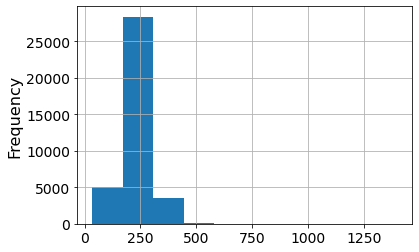

100%|██████████| 13/13 [00:00<00:00, 456.16it/s]

********** 4. Creating Doc 2 cluster Map ************

Finished running 'cluster2doc' in 0.0001 mins

*********** 5. Filtering Clusters ****************
Number of Filtered Clusters : 13
*********** 6. Scoring Clusters based on Keyword Precsence *************


In [34]:
doc_2_cluster_map, cps, rel_df = prepare_data(path="../sampled_articles_from_relevant_data.csv",num_clusters=50,min_c_size=400,max_c_size=4000,partisan_dist_diff=0.4,extreme=True,return_data=True)

In [36]:
cps

[(7, 1.471476510067114),
 (15, 1.368306486721811),
 (28, 1.1294117647058823),
 (25, 1.085249579360628),
 (48, 0.9256198347107438),
 (13, 0.9181818181818182),
 (47, 0.8682417083144025),
 (35, 0.7155049786628734),
 (3, 0.7018348623853211),
 (18, 0.6272563176895307),
 (44, 0.4776490066225166),
 (36, 0.2625523012552301),
 (41, 0.25102880658436216)]

In [35]:
analyze_cps(cps=cps,df=rel_df,cluster_2_doc_map=doc_2_cluster_map)


******* (7, 1.471476510067114) ***********



title  \
193                                                                                McConnell: Impeachment Distracted Government From Wuhan Virus   
213                                                                 Joe Biden Nixes Deal That Would Have Him Testify In Senate Impeachment Trial   
229                                                                                McConnell takes aim at Ocasio-Cortez with Green New Deal vote   
308  The man who went viral after snubbing McConnell at Elijah Cummings’ memorial blamed Senate majority leader for holding up veterans benefits   
326                                                                    Did the Senate Majority Leader just issue a warning — or was it a threat?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

Empty DataFrame
Columns: [title, text]
Index: []


******* (15, 1.368306486721811) ***********



title  \
54                                                  Nunes kicks off impeachment hearing by smearing the witnesses   
80   GOP congressman blasts Trump for quoting evangelical pastor's ‘civil war’ threat: ‘This is beyond repugnant’   
98                                                      Rob Reiner: Donald Trump 'Defecating on Our Constitution'   
112                                Roger Stone Found Guilty on All Seven Counts. Will His Defense Work for Trump?   
114                   Nunes Opens Impeachment Hearings by Attacking Media ‘Puppets’ for Inaccurate Trump Coverage   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

Empty DataFrame
Columns: [title, text]
Index: []


******* (28, 1.1294117647058823) ***********



title  \
31                                California Admits DMV Error Added Non-Citizens To Voter Rolls   
126                                    The scandal in North Carolina proves voter fraud is real   
210                        Trump Encourages Use of Mail-In Ballots in Florida in Stark Reversal   
262                                                         Friday's Campaign Round-Up, 4.10.20   
392  PA Gov. Wolf Asks for Extension of Mail-In Vote Deadline After U.S. Postal Service Warning   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

Empty DataFrame
Columns: [title, text]
Index: []


******* (25, 1.085249579360628) ***********



title  \
16                                               Poll: Minnesota Now in Play as Biden Lead Slips to Three   
28                                                   How Republicans Can Win Over Minority Voters in 2020   
49   Some Tea Party Republicans in South Carolina are voting for Bernie Sanders in the Democratic primary   
82                                                                     Friday's Campaign Round-Up, 8.7.20   
160                                            Billionaire Tom Steyer Drops Out Of 2020 Presidential Race   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

Empty DataFrame
Columns: [title, text]
Index: []


******* (48, 0.9256198347107438) ***********



title  \
15               The truth about Sanders' Cold War comments is too complicated for cable news   
89                                                       The Nordic Democratic-Socialist Myth   
97                                   Bernie Sanders Is the Developing World’s Worst Nightmare   
116                                                            You Still Can’t Beat City Hall   
138  After Second-Place Finish in Super Tuesday, Bernie Sanders Now Has An Ad Featuring Obama   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

Empty DataFrame
Columns: [title, text]
Index: []


******* (13, 0.9181818181818182) ***********



title  \
36   Kamala Harris Co-Sponsored Bill That Would Force Schools To Let Male Athletes Compete In Girls&#8217; Sports   
73                                                    5 things Sen. Kamala Harris has done besides be interrupted   
94                               Watch: Kamala Harris Calls Kavanaugh's Pocket Constitution 'That Book You Carry'   
104        Kamala Harris Wouldn’t Apologize For Cynical Attack On Biden During Debate, Might Not Be ‘Lock’ For VP   
131                                          Trump Promises to ‘Take a Look’ at Bogus Kamala Harris Birther Claim   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

Empty DataFrame
Columns: [title, text]
Index: []


******* (47, 0.8682417083144025) ***********



title  \
2                                    Liz Cheney on Ukraine: 'Starting to Seem Like a Political Setup'   
5                            Diplomats Were Told to Stay Quiet About Ukraine Military Aid Freeze: NYT   
19                 Trump Asked Zelensky to Work with Giuliani to Investigate Origins of Mueller Probe   
29                                       Meghan McCain says Trump should 'definitely be investigated'   
39  Trump just gave away the game on his bribery scheme in a live interview to baffled Fox News hosts   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

Empty DataFrame
Columns: [title, text]
Index: []


******* (35, 0.7155049786628734) ***********



title  \
3                                                                          ThinkProgress Smears Dan Crenshaw on ‘Universal Background Checks’   
10                                                                     If You're Trying To Ban Guns, The Least You Can Do Is Learn The Basics   
17                                                                      Republicans Blocked A Gun Control Bill During Another School Shooting   
30                                                                                       New Zealand Gun Buyback Was An ‘Unmitigated Failure’   
43  Virginia Sheriff Chad Cubbage: ‘My Staff And I Stand Ready To Protect The Citizens Of Page County From Their Rights Being Infringed Upon’   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

Empty DataFrame
Columns: [title, text]
Index: []


******* (3, 0.7018348623853211) ***********



title  \
23                                    Bernie Sanders’s free college proposal just got a whole lot bigger   
88   Republicans prove they'll never miss an opportunity to help the top 1% — not even during a pandemic   
110                                                              100 years of tax brackets, in one chart   
158                                   Weed Tax Shortfall Taught California The Logic Of The Laffer Curve   
159                                                                                    The Real Fat Cats   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

Empty DataFrame
Columns: [title, text]
Index: []


******* (18, 0.6272563176895307) ***********



title  \
58   Trump's Lawyers Argue Congress Has Little Power To Investigate A Sitting President's Personal Affairs   
61                                             Even With Court Ruling, Trans Rights Are Still Under Threat   
84                 Trump’s Impeachment Trial Won’t Keep The Chief Justice Away From The State Of The Union   
99                       Supreme Court Allows Trump Admin to Implement ‘Public Charge’ Test for Immigrants   
103                            The Supreme Court’s landmark new Native American rights decision, explained   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

Empty DataFrame
Columns: [title, text]
Index: []


******* (44, 0.4776490066225166) ***********



title  \
40                                            America Needs More Ventilators. Here’s How We Can Get Them.   
105      California is about to be the first state to expand health care to young unauthorized immigrants   
148        Trump says the federal coronavirus effort has been "incredible." His own government disagrees.   
161                                                               Obamacare sign-ups surge in final tally   
190  Members Of Congress Got Tested For The Coronavirus Despite Not Showing Symptoms, And Now We Know How   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

Empty DataFrame
Columns: [title, text]
Index: []


******* (36, 0.2625523012552301) ***********



title  \
24                                                          The Options on Iran Run from Bad to Risky   
53                                            Who was the Iranian general killed by a U.S. airstrike?   
96          WATCH: U.S. Forces Arrive At Embassy In Baghdad To Stop Attack; Trump Drops Big Statement   
111                               Officials: Planned attacks on U.S. targets spurred Soleimani strike   
140  Bernie Sanders: Saudi Arabia Is “Not an Ally” and the U.S. Should “Rethink” Its Approach to Iran   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

Empty DataFrame
Columns: [title, text]
Index: []


******* (41, 0.25102880658436216) ***********



title  \
1                                                              Trump's draconian border lockdown has a new target   
69                Trump wanted to shoot migrants and build a wall guarded by alligators and flesh-piercing spikes   
72                                        Trump Is Trampling Dozens of Laws to Build His Border Wall. Here’s How.   
101  'Propaganda': Immigration Activist Group Raices Slams Netflix Series 'Border Security: America's Front Line'   
129                                                                A brief guide to the State of the Union guests   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

Empty DataFrame
Columns: [title, text]
Index: []

In [10]:
rel_df = load_pickle("Data_4_AttM/rel_df.pkl")

In [11]:
save_bert_embeddings(df=rel_df,save_path="/media/karthikshivaram/SABER_4TB/attm_bert_embeddings/token_bert_12_embeds_attm.hdf5",batch_size=100,max_length=350)

  0%|          | 0/992 [00:00<?, ?it/s]

Num Batches : 992
Dataset Shape : (99200, 350, 768)


100%|██████████| 992/992 [39:56<00:00,  2.42s/it]  


In [12]:
rel_df = load_pickle("Data_4_AttM/rel_df_extreme.pkl")

In [13]:
save_bert_embeddings(df=rel_df,save_path="/media/karthikshivaram/SABER_4TB/attm_bert_embeddings/token_bert_12_embeds_attm_extreme.hdf5",batch_size=100,max_length=300)

  0%|          | 0/368 [00:00<?, ?it/s]

Num Batches : 368
Dataset Shape : (36800, 300, 768)


100%|██████████| 368/368 [11:52<00:00,  1.94s/it]


In [15]:
words = []
idx = 0
word2idx = {}
glove_path=".."
vectors = []
with open(f'{glove_path}/glove.6B.300d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vect = np.array(line[1:]).astype(np.float)
        vectors.append(vect)
    

In [16]:
print(len(vectors))

400000


In [17]:
print(len(words))

400000


In [18]:
print(len(word2idx))

400000


In [19]:
vectors = np.array(vectors)
print(vectors.shape)

(400000, 300)


In [20]:
glove_path = "Data_4_AttM"

In [21]:
pickle.dump(vectors,open(f'{glove_path}/6B.300_vectors.pkl', 'wb'))
pickle.dump(words, open(f'{glove_path}/6B.300_words.pkl', 'wb'))
pickle.dump(word2idx, open(f'{glove_path}/6B.300_idx.pkl', 'wb'))

In [22]:
vectors = pickle.load(open(f'{glove_path}/6B.300_vectors.pkl', 'rb'))
words = pickle.load(open(f'{glove_path}/6B.300_words.pkl', 'rb'))
word2idx = pickle.load(open(f'{glove_path}/6B.300_idx.pkl', 'rb'))

glove = {w: vectors[word2idx[w]] for w in words}

In [23]:
glove["the"]

array([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
        2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
       -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
        2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
       -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
       -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
        9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
       -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
        1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
        2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
        1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
        2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
       -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
       -4.4640e-01,  1.7197e-01,  4.6246e-02,  5.8639e-02,  4.14

In [25]:
def get_target_vocab(text_list):
    """
    """
    tokens = [word_tokenize(text) for text in text_list]
    tokens_flat = [j for i in tokens for j in i]
    tokens_unique = list(set(tokens_flat))
    print("Num of Tokens : %s"%str(len(tokens_flat)))
    print("Vocab Size : %s"%str(len(tokens_unique)))
    return tokens_unique


def save_wm(text_list,glove,extreme=False):
    """
    We save vocab to convert tokens to indices 
    """
    target_vocab = get_target_vocab(text_list)
    matrix_len = len(target_vocab)
    weights_matrix = np.zeros((matrix_len, 300))
    words_found = 0

    for i, word in enumerate(target_vocab):
        try: 
            weights_matrix[i] = glove[word]
            words_found += 1
        except KeyError:
            weights_matrix[i] = np.random.normal(scale=0.6, size=(300, ))
    
    print("Words Found : %s" %str(words_found))
    
    if extreme:
        save_obj(path="Data_4_AttM/glove_mat_extreme.pkl",obj=weights_matrix)
        save_obj(path="Data_4_AttM/vocab_target_glove_extreme.pkl",obj=target_vocab)
    
    if not extreme:
        save_obj(path="Data_4_AttM/glove_mat.pkl",obj=weights_matrix)
        save_obj(path="Data_4_AttM/vocab_target_glove.pkl",obj=target_vocab)

In [26]:
rel_df = load_pickle("Data_4_AttM/rel_df.pkl")

In [29]:
save_wm(rel_df["all_text"].tolist(),glove,extreme=False)

Num of Tokens : 22243896
Vocab Size : 102445
Words Found : 77958


In [30]:
rel_df = load_pickle("Data_4_AttM/rel_df_extreme.pkl")

In [31]:
save_wm(rel_df["all_text"].tolist(),glove,extreme=True)

Num of Tokens : 8476668
Vocab Size : 71460
Words Found : 59495


## Keep Max Length of 350 Tokens when Using Bert Tokenizer for normal dataset
## Keep Max Length of 300 Tokens when using Bert Tokenizer for extreme dataset

## Vectorization and Clustering

In [24]:
vectors,vocab,tfidf_vectorizer = tfidf_vectorization(df=rel_df,min_df=50,max_df=0.75,seed=RANDOM_SEED,max_features=20000,combine_text=False)

vocab_size : 15026

Finished running 'tfidf_vectorization' in 0.1702 mins




Running KMEANS Clustering with k=50

Finished running 'run_clustering' in 0.1419 mins


Finished running 'get_cluster_sizes' in 0.0002 mins



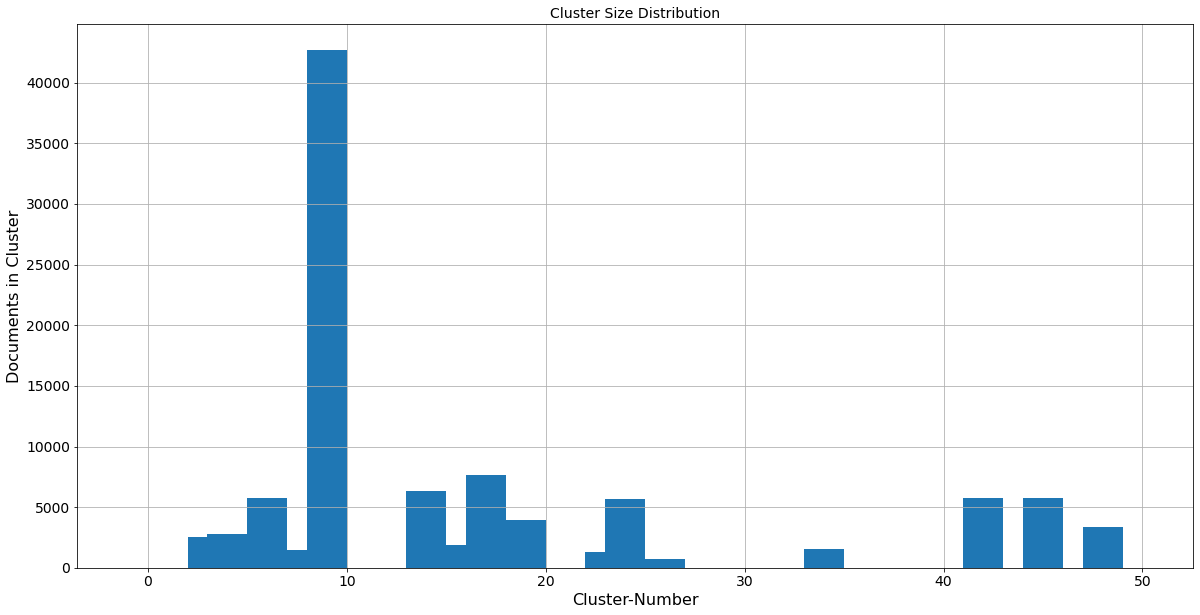

In [60]:
clusters,cluster_clf = run_clustering(vectors=vectors,seed=RANDOM_SEED,num_clusters=50,clus_type="kmeans")

cluster_sizes = get_cluster_sizes(cluster_clf)

plot_size_dist(cluster_sizes)

In [61]:
cluster_sizes.keys()

dict_keys([9, 45, 48, 19, 42, 3, 8, 26, 23, 17, 6, 14, 15, 34, 4, 24, 33, 46, 41, 5, 16, 40, 38, 47, 22, 1, 21, 25, 20, 31, 30, 13, 10, 39, 2, 27, 32, 43, 37, 29, 18, 36, 49, 35, 0, 44, 11, 12, 7, 28])

In [81]:
cluster_sizes[26]

721

* 95 - Immigration/ Border Wall
* 62 - Supreme court related issues
* 45 - Trump related + Trump Impeachment
* 72 - Taliban Related
* 54 - Trump Impeachment
* 99 - Welfare + stimulus checks
* 3 - Racism
* 85 - Trump Impeachment - Ukraine Related
* 70 - US Elections
* 30 - US Military

In [ ]:
48 - Immigration (3344)
19 - Law/ Crime/ Supreme Court (3924)
42 - Trump Impeachment (5793)
3 - Welfare/Stimulus (2556)
8 - Racism (1509)
26 - Technology / Big Tech (721)

In [69]:
doc_2_cluster_map = cluster2doc(num_texts=rel_df.shape[0],cluster_labels=cluster_clf.labels_)


Finished running 'cluster2doc' in 0.0003 mins



In [80]:
with open("doc_2_cluster_k_50.pkl","wb") as wb:
    pickle.dump(doc_2_cluster_map,wb)

In [82]:
c1_df = rel_df.iloc[doc_2_cluster_map[26]]

c1_df.head(5)

title  \
14   Adriana Cohen: Twitter not only politically biased, it's crossed over into election meddling, too   
136                                                      New 5G coalition features Facebook, Microsoft   
227                                                                 Friday's Campaign Round-Up, 8.7.20   
453               Opinion | Elizabeth Warren's plan for big tech makes her the Teddy Roosevelt of 2020   
486                                                    Obama 2012 and Google: Your Privacy, Diminished   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [30]:
len(doc_2_cluster_map[171])

671

In [31]:
def filter_clusters_size(cluster_sizes,min_size=300,max_size=3000):
    """
    """
    filtered_clusters = []
    for cluster in cluster_sizes.keys():
        if cluster_sizes[cluster] >= min_size and cluster_sizes[cluster] <= max_size:
            filtered_clusters.append(cluster)
    return filtered_clusters

def filter_by_partisan_dist(clusters,cluster_2_doc_map,df,partisan_dist_diff=0.20):
    """
    """
    filtered_clusters = []
    for c in clusters:
        print(c)
        c_docs_indices = cluster_2_doc_map[c]
        total_size = len(c_docs_indices)
        c_df = df["binary_ps"].iloc[c_docs_indices]
        ps_dist = c_df.value_counts().tolist()
        pos_dist = ps_dist[-1]/total_size
        neg_dist = ps_dist[0]/total_size
        dist_diff = np.abs(pos_dist - neg_dist)
        
        print("Dist_diff : %s" %str(dist_diff))
        
        if dist_diff <= partisan_dist_diff:
            filtered_clusters.append(c)
    
    return filtered_clusters

In [32]:
fil_clusters = filter_clusters_size(cluster_sizes,min_size=300,max_size=3000)

In [33]:
len(fil_clusters)

86

In [34]:
fil_ps_clusters = filter_by_partisan_dist(clusters=fil_clusters,
                                          cluster_2_doc_map=doc_2_cluster_map,
                                          df=rel_df,
                                          partisan_dist_diff=0.30)

84
Dist_diff : 0.19999999999999996
88
Dist_diff : 0.31363203050524313
129
Dist_diff : 0.3175074183976261
78
Dist_diff : 0.23887375113533155
126
Dist_diff : 0.1553648068669528
123
Dist_diff : 0.21028037383177572
35
Dist_diff : 0.15706806282722519
51
Dist_diff : 0.38028169014084506
113
Dist_diff : 0.2122370936902485
149
Dist_diff : 0.2173913043478261
270
Dist_diff : 0.3466666666666667
60
Dist_diff : 0.07647058823529407
252
Dist_diff : 0.459915611814346
56
Dist_diff : 0.49248120300751874
220
Dist_diff : 0.10852017937219727
75
Dist_diff : 0.06821705426356589
227
Dist_diff : 0.23642439431913115
243
Dist_diff : 0.4369369369369369
379
Dist_diff : 0.18077803203661325
47
Dist_diff : 0.12896622313203682
23
Dist_diff : 0.031192660550458662
58
Dist_diff : 0.04766146993318482
206
Dist_diff : 0.41333333333333333
49
Dist_diff : 0.12313432835820892
306
Dist_diff : 0.11323896752706081
70
Dist_diff : 0.2907348242811501
288
Dist_diff : 0.3333333333333333
5
Dist_diff : 0.012318029115341522
66
Dist_diff : 

In [35]:
print(len(fil_ps_clusters))

58


In [36]:
def create_cluster_pairs(clusters):
    cluster_pairs = []
    for pair in itertools.combinations(clusters,2):
        
        cluster_pairs.append(pair)
    
    return cluster_pairs

In [37]:
cluster_pairs = create_cluster_pairs(fil_ps_clusters)

In [38]:
print(len(cluster_pairs))

1653


In [39]:
def select_top_n_similar_cps(cps,cluster_clf,n=10):
    """
    """
    dist_matrix = cosine_similarity(cluster_clf.cluster_centers_)
    sorted_cps = sorted(cps,key=lambda x: dist_matrix[x[0],x[1]],reverse=True)[:n]
    return sorted_cps

In [40]:
top_10_sim_cps = select_top_n_similar_cps(cps=cluster_pairs,
                                          cluster_clf=cluster_clf,
                                          n=20)

In [41]:
top_10_sim_cps

[(58, 59),
 (123, 59),
 (66, 8),
 (47, 49),
 (58, 66),
 (349, 63),
 (81, 349),
 (306, 281),
 (23, 156),
 (66, 59),
 (123, 58),
 (49, 306),
 (58, 8),
 (23, 306),
 (173, 314),
 (126, 301),
 (220, 98),
 (123, 66),
 (81, 63),
 (23, 49)]

In [42]:
def analyze_cps(cps,df,cluster_2_doc_map):
    """
    """
    for cp in cps:
        print("\n******* %s ***********\n"%str(cp))
        c1_df = df.iloc[cluster_2_doc_map[cp[0]]]
        c2_df = df.iloc[cluster_2_doc_map[cp[1]]]
        
        display(c1_df[["title","text"]].head(5))
        print("\n")
        display(c2_df[["title","text"]].head(5))

In [43]:
analyze_cps(cps=top_10_sim_cps,df=rel_df,cluster_2_doc_map=doc_2_cluster_map)


******* (58, 59) ***********



title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


******* (123, 59) ***********



title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                text
7                    Liz Cheney on Ukraine: 'Starting to Seem Like a Political Setup'  Rep. Liz Cheney (R-WY) on Monday said an intelligence official’s complaint that President Trump sought help from Ukraine in the 2020 elections “is starting to seem like a political setup.”          Cheney tweeted a clip of House Speaker Nancy Pelosi (D-CA) appearing to admit she knew what was in the transcript of a July 25 Trump phone call with Ukrainian leader Volodymyr Zelensky even before the White House released the transcript of the call last Wednesday.          Pelosi, in an interview that aired Sunday on CBS News 60 Minutes, said Trump called her and they discussed the phone call before the transcript was released.          According to the New York Times, Trump and Pelosi’s phone call took place on Tuesday. The White House released the transcript on Wednesday.          But Pelosi said during the interview about her call with Trump, “He told me it was perfect. There was nothing in the call. But I know what was in the call. I mean, we — it was in the public domain.”          When Trump and Pelosi had spoken Tuesday, the call was not yet “in the public domain.”          Fred Fleitz, a former CIA analyst and chief of staff to former National Security Adviser John Bolton, has questioned whether the intelligence official who lodged a whistle

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


******* (66, 8) ***********



title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


******* (47, 49) ***********



title  \
44                    The truth about Sanders' Cold War comments is too complicated for cable news   
96                                       Bernie Sanders: ‘This is not the time for a protest vote’   
167                    Former RNC official sees 'ghosts' of Trump's 2016 race in Sanders' campaign   
243                                                           The Nordic Democratic-Socialist Myth   
244  ‘Disappointed’: Elizabeth Warren blasts Bernie Sanders after volunteers’ canvass script leaks   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


******* (58, 66) ***********



title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


******* (349, 63) ***********



title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


******* (81, 349) ***********



title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


******* (306, 281) ***********



title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            text
55   Joe Biden attacks Donald Trump for 'shameful' claim he is 'against God'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            Donald Trump has claimed Joe Biden is “against God” in an attack on the presumptiv

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


******* (23, 156) ***********



title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


******* (66, 59) ***********



title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


******* (123, 58) ***********



title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                text
7                    Liz Cheney on Ukraine: 'Starting to Seem Like a Political Setup'  Rep. Liz Cheney (R-WY) on Monday said an intelligence official’s complaint that President Trump sought help from Ukraine in the 2020 elections “is starting to seem like a political setup.”          Cheney tweeted a clip of House Speaker Nancy Pelosi (D-CA) appearing to admit she knew what was in the transcript of a July 25 Trump phone call with Ukrainian leader Volodymyr Zelensky even before the White House released the transcript of the call last Wednesday.          Pelosi, in an interview that aired Sunday on CBS News 60 Minutes, said Trump called her and they discussed the phone call before the transcript was released.          According to the New York Times, Trump and Pelosi’s phone call took place on Tuesday. The White House released the transcript on Wednesday.          But Pelosi said during the interview about her call with Trump, “He told me it was perfect. There was nothing in the call. But I know what was in the call. I mean, we — it was in the public domain.”          When Trump and Pelosi had spoken Tuesday, the call was not yet “in the public domain.”          Fred Fleitz, a former CIA analyst and chief of staff to former National Security Adviser John Bolton, has questioned whether the intelligence official who lodged a whistle

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


******* (49, 306) ***********



title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            text
55   Joe Biden attacks Donald Trump for 'shameful' claim he is 'against God'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            Donald Trump has claimed Joe Biden is “against God” in an attack on the presumptiv


******* (58, 8) ***********



title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


******* (23, 306) ***********



title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            text
55   Joe Biden attacks Donald Trump for 'shameful' claim he is 'against God'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            Donald Trump has claimed Joe Biden is “against God” in an attack on the presumptiv


******* (173, 314) ***********



title  \
98                            Coronavirus on the border: California hospitals overwhelmed by patients from Mexico   
154                                          House Republicans demand details on Dems' mysterious trips to Mexico   
198               Trump wanted to shoot migrants and build a wall guarded by alligators and flesh-piercing spikes   
272  'Propaganda': Immigration Activist Group Raices Slams Netflix Series 'Border Security: America's Front Line'   
330                                                                A brief guide to the State of the Union guests   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

title  \
203                             Trump Is Trampling Dozens of Laws to Build His Border Wall. Here’s How.   
366                           Judge Allows Trump Admin to Survey Historic Church’s Land for Border Wall   
1294  Opinion | Trump’s border wall wouldn’t stop most illegal immigration or drugs. So what is it for?   
1992                        Defense Department Approves Funding For 20 Miles of U.S./Mexico Border Wall   
2084                            These Wall Street Companies Are Ready to Cash In on Trump’s Border Wall   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               


******* (126, 301) ***********



title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


******* (220, 98) ***********



title  \
27                              If You're Trying To Ban Guns, The Least You Can Do Is Learn The Basics   
42  Analysis | Marco Rubio’s claim that no recent mass shootings would have been prevented by gun laws   
49                               Republicans Blocked A Gun Control Bill During Another School Shooting   
86                                                New Zealand Gun Buyback Was An ‘Unmitigated Failure’   
94                                           Fighting gun trafficking gets ensnared in political fight   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


******* (123, 66) ***********



title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                text
7                    Liz Cheney on Ukraine: 'Starting to Seem Like a Political Setup'  Rep. Liz Cheney (R-WY) on Monday said an intelligence official’s complaint that President Trump sought help from Ukraine in the 2020 elections “is starting to seem like a political setup.”          Cheney tweeted a clip of House Speaker Nancy Pelosi (D-CA) appearing to admit she knew what was in the transcript of a July 25 Trump phone call with Ukrainian leader Volodymyr Zelensky even before the White House released the transcript of the call last Wednesday.          Pelosi, in an interview that aired Sunday on CBS News 60 Minutes, said Trump called her and they discussed the phone call before the transcript was released.          According to the New York Times, Trump and Pelosi’s phone call took place on Tuesday. The White House released the transcript on Wednesday.          But Pelosi said during the interview about her call with Trump, “He told me it was perfect. There was nothing in the call. But I know what was in the call. I mean, we — it was in the public domain.”          When Trump and Pelosi had spoken Tuesday, the call was not yet “in the public domain.”          Fred Fleitz, a former CIA analyst and chief of staff to former National Security Adviser John Bolton, has questioned whether the intelligence official who lodged a whistle

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


******* (81, 63) ***********



title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           


******* (23, 49) ***********



title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [44]:
with open("current_pickle_obs/top10cp.pickle","wb") as fp:
    pickle.dump(top_10_sim_cps,fp)

In [45]:
with open("current_pickle_obs/doc_2_cluster_map.pickle","wb") as fp:
    pickle.dump(doc_2_cluster_map,fp)

In [46]:
with open("current_pickle_obs/rel_df.pickle","wb") as fp:
    pickle.dump(rel_df,fp)

In [47]:
top_10_sim_cps = load_pickle("current_pickle_obs/top10cp.pickle")

In [48]:
doc_2_cluster_map = load_pickle("current_pickle_obs/doc_2_cluster_map.pickle")

In [49]:
rel_df = load_pickle("current_pickle_obs/rel_df.pickle")

## Bert Embeddings Saving

For each of these clusters in our cluster pairs
* Save the corresponding bert embeddings 

In [7]:
def save_bert_embeddings(df,save_path="/media/karthikshivaram/SABER_4TB/attm_bert_embeddings/token_bert_12_embeds_attm.hdf5",batch_size=100):
    """
    I need to batch infer but save them with original doc indices
    """
    texts = df["all_text"].tolist()
    model = load_model()
    model.to(torch.device('cuda:1'))
    tokenizer = load_tokenizer()
    
    with h5py.File(save_path, "w") as f:
        
        dset = f.create_dataset("bert_embeds",shape=(int(df.shape[0]/batch_size)+1,350,768),dtype="float32")
        start_ind = 0
        with torch.no_grad():
            for batch_num,batched_text in enumerate(tqdm(batch_text_gen(texts,batch_size=batch_size),total=int(df.shape[0]/batch_size)+1)):
                encoded_batch = tokenizer.batch_encode_plus(batched_text, add_special_tokens=True, max_length = 350, padding='max_length', return_attention_mask = False,truncation=True, return_tensors = 'pt')
                token_tensors = encoded_batch["input_ids"]
                token_tensors = token_tensors.to(torch.device('cuda:1'))
                batch_out = model(token_tensors)
                batch_hidden_states = batch_out[2]
                batch_12_layer_tensor = batch_hidden_states[-1]
#                 start_ind = batch_num*batch_size
#                 end_ind = (batch_size*batch_num)+batch_size
                
                end_ind = start_ind + batch_12_layer_tensor.size()[0]
                dset[start_ind:end_ind,:,:] = batch_12_layer_tensor.cpu().numpy()
                start_ind = end_ind
                f.flush()

In [8]:
# save_bert_embeddings(df=rel_df,batch_size=100)

100%|██████████| 995/995 [39:27<00:00,  2.38s/it]  


In [ ]:
# save_bert_embeddings(df=rel_df_extreme,batch_size=100,save_path ="/media/karthikshivaram/SABER_4TB/attm_bert_embeddings/token_bert_12_embeds_attm_extreme.hdf5" )

In [11]:
with h5py.File("/media/karthikshivaram/SABER_4TB/attm_bert_embeddings/token_bert_12_embeds_attm.hdf5", "r") as f:
    d_set = f.get("bert_embeds")
    print(d_set[99,:,:].shape)
    print(d_set[199,:,:].shape)
    print(d_set[99,:,:] == d_set[199,:,:] )

(350, 768)
(350, 768)
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


## Context Word Sampling with Embeddings

* Create tf-idf vectors from headlines only
* Get tokens with corresponding tf-idf values
* Sort in descending order, select only a small sample
* pick how many ever you want (for us it is 3)
* For negative do same but just check to make sure token not in title

* Compare sampling from headline vs sampling from all text

In [69]:
def vectorize_text(text_list):
    """
    """
    tfidf_vectorizer = TfidfVectorizer(min_df=30, binary=False, max_df=0.90, stop_words='english',max_features=None)
    tf_idf_vectors = tfidf_vectorizer.fit_transform(text_list)
    print("Vocab Size : %s "%str(len(tfidf_vectorizer.get_feature_names())))
    return tf_idf_vectors, tfidf_vectorizer

def get_tokens(text_list,batch_size=100,max_length=15):
    tokenizer = load_tokenizer()
    all_toks = []
    for batch_num,batched_text in enumerate(tqdm(batch_text_gen(text_list,batch_size=batch_size),total=int(len(text_list)/batch_size)+1)):
        encoded_batch = tokenizer.batch_encode_plus(batched_text, add_special_tokens=True, max_length = max_length, padding='max_length', return_attention_mask = False,truncation=True, return_tensors = 'pt')
        token_tensors = encoded_batch["input_ids"] # 2d , (batch_size,max_length)
        batched_toks = []
        for sent in range(token_tensors.size()[0]):
            sent_toks = []
            tokens = tokenizer.convert_ids_to_tokens(token_tensors[sent])
            for t in tokens:
                if t not in ['[SEP]', '[PAD]']:
                    sent_toks.append(t)
            batched_toks.append(sent_toks)
        
        all_toks += batched_toks
    
    return all_toks

def sample_pos_context_word(tokens,tfidf_vec,tf_idf_vectorizer,search_range=20,sample_size=2):
    """
    """
    sampled_words = []
    tokenslc = [t.lower() for t in tokens]
    # high tfidf terms in text argsort descending
    sorted_indices = np.argsort(tfidf_vec.todense())[::-1].tolist()[0]
    sorted_tokens_tfidf = np.array(tf_idf_vectorizer.get_feature_names())[sorted_indices]
    # bert tokens of text
    for tftoken in sorted_tokens_tfidf.tolist():
        if tftoken in tokenslc:
            sampled_words.append(tftoken)

        if len(sampled_words) == sample_size:
            break
    return sampled_words

def sample_neg_context_word(tokens,pos_words_set,sample_size=2):
    """
    """
    tokenslc = [t.lower() for t in tokens]
    sampled_words = []
    hard_stop = 0
    while True:
        sw = random.choice(pos_words_set)
        hard_stop +=1
        if sw not in tokenslc:
            sampled_words.append(sw)
        
        if len(sampled_words) == sample_size:
            break
        
        if hard_stop == 20:
            break
        
    return sampled_words
            

def sample_context_words(df,tfidf_vecs,all_tokens,tf_idf_vectorizer,sample_size=3,search_range=20):
    """
    """
    sampled_pos = []
    all_pos = []
    sampled_neg = []
    for i in tqdm(range(df.shape[0]),total=df.shape[0]):
        
        sample_pos = sample_pos_context_word(tokens=all_tokens[i],
                                             tfidf_vec=tfidf_vecs[i],
                                             tf_idf_vectorizer=tf_idf_vectorizer,
                                             search_range=search_range,
                                             sample_size=sample_size)
    
        sampled_pos.append(sample_pos)
        all_pos = all_pos + sample_pos
    
    sampled_pos_unique = list(set(all_pos))
    
    print("Pos tokens size : %s"%str(len(all_pos)))
    print("Pos vocab size : %s"%str(len(sampled_pos_unique)))
    
    for i in tqdm(range(df.shape[0]),total=df.shape[0]):
        
        sample_neg = sample_neg_context_word(tokens=all_tokens[i],
                                             pos_words_set=sampled_pos_unique,
                                             sample_size=sample_size)
        
        sampled_neg.append(sample_neg)
    
    unsampled_pos = 0
    unsampled_neg = 0
    
    for i in tqdm(range(df.shape[0]),total=df.shape[0]):
        
        if len(sampled_pos[i]) < sample_size:
            unsampled_pos +=1
        
        if len(sampled_neg[i]) < sample_size:
            unsampled_neg +=1
    
    print("Articles missing a pos context word : %s"%str(unsampled_pos))
    print("Articles missing a neg context word : %s"%str(unsampled_neg))
    
    return sampled_pos, sampled_neg
    
        

### Sampling Context words from Headline

In [51]:
headline_tfvecs , headline_vectorizer = vectorize_text(rel_df["processed_title"])

Vocab Size : 3813 


In [52]:
headline_tfvecs.shape

(99403, 3813)

In [53]:
headline_tfvecs[0].shape

(1, 3813)

In [54]:
headline_tfvecs[0].shape

(1, 3813)

In [55]:
headline_tfvecs[0].todense().flatten().shape

(1, 3813)

In [56]:
all_tokens_hd = get_tokens(text_list=rel_df["processed_title"].tolist(),batch_size=100)

100%|██████████| 995/995 [00:25<00:00, 39.34it/s]


In [57]:
print(len(all_tokens_hd))

99403


In [58]:
print(all_tokens_hd[4])

['[CLS]', 'supreme', 'court', 'clears', 'way', 'for', 'execution', 'of', 'federal', 'prisoner']


In [59]:
print(len(all_tokens_hd[4]))

10


In [60]:
sampled_pos, sampled_neg = sample_context_words(df=rel_df,
                                                tfidf_vecs=headline_tfvecs,
                                                all_tokens=all_tokens_hd,
                                                tf_idf_vectorizer=headline_vectorizer,
                                                sample_size=3,
                                                search_range=20)

 28%|██▊       | 27397/99403 [00:00<00:00, 273964.38it/s]

Pos tokens size : 290423
Pos vocab size : 3198


100%|██████████| 99403/99403 [00:00<00:00, 2729969.49it/s]

Articles missing a pos context word : 5922
Articles missing a neg context word : 0


In [61]:

less_than_1 = 0
less_than_1_ids = []
for i,s in enumerate(sampled_pos):
    if len(s) < 1:
        less_than_1+=1
        less_than_1_ids.append(i)

In [62]:
less_than_1

232

In [63]:
less_than_1_ids[:10]

[502, 1489, 1687, 2128, 2352, 2757, 3230, 3653, 3900, 4133]

In [64]:
rel_df["context_pos_words"] = sampled_pos
rel_df["context_neg_words"] = sampled_neg

In [65]:
rel_df["context_neg_words"] = sampled_neg

In [66]:
with open("current_pickle_obs/rel_df_with_wp.pickle","wb") as fp:
    pickle.dump(rel_df,fp)

In [68]:
rel_df.head(1)

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             text  source_partisan_score  binary_ps                                                                                                                                                                                                                                                        

### Sampling Context words from Text

In [70]:
body_tfvecs , body_vectorizer = vectorize_text(rel_df["processed_text"])

Vocab Size : 18801 


In [71]:
body_tfvecs.shape

(99403, 18801)

In [72]:
body_tfvecs[0].shape

(1, 18801)

In [73]:
body_tfvecs[0].shape

(1, 18801)

In [74]:
body_tfvecs[0].todense().flatten().shape

(1, 18801)

In [75]:
all_tokens_body = get_tokens(text_list=rel_df["processed_text"].tolist(),batch_size=100,max_length=350)

100%|██████████| 995/995 [06:10<00:00,  2.69it/s]


In [76]:
print(len(all_tokens_body))

99403


In [77]:
print(all_tokens_body[4])

['[CLS]', 'terre', 'haute', 'ind', 'the', 'trump', 'administration', 'was', 'moving', 'ahead', 'early', 'tuesday', 'with', 'the', 'execution', 'the', 'first', 'federal', 'prison', 'inmate', 'years', 'after', 'divided', 'supreme', 'court', 'reversed', 'lower', 'courts', 'and', 'ruled', 'federal', 'executions', 'could', 'proceed', 'daniel', 'lewis', 'lee', 'had', 'been', 'scheduled', 'receive', 'lethal', 'dose', 'the', 'powerful', 'se', '##da', '##tive', 'pen', '##to', '##bar', '##bit', '##al', 'ed', '##t', 'monday', 'but', 'court', 'order', 'issued', 'monday', 'morning', 'district', 'judge', 'tanya', 'chu', '##t', '##kan', 'prevented', 'lee', 'execution', 'federal', 'appeals', 'court', 'washington', 'refused', 'the', 'administration', 'plea', 'step', 'leaving', 'the', 'hold', 'place', 'before', 'the', 'supreme', 'court', 'acted', 'vote', 'still', 'lee', 'lawyers', 'insisted', 'the', 'execution', 'could', 'not', 'forward', 'after', 'midnight', 'under', 'federal', 'regulations', 'with', '

In [78]:
print(len(all_tokens_body[4]))

173


In [79]:
sampled_pos, sampled_neg = sample_context_words(df=rel_df,
                                                tfidf_vecs=body_tfvecs,
                                                all_tokens=all_tokens_body,
                                                tf_idf_vectorizer=body_vectorizer,
                                                sample_size=3,
                                                search_range=20)

  3%|▎         | 3383/99403 [00:00<00:02, 33828.82it/s]

Pos tokens size : 298209
Pos vocab size : 5180


100%|██████████| 99403/99403 [00:00<00:00, 2631479.82it/s]

Articles missing a pos context word : 0
Articles missing a neg context word : 0


In [80]:

less_than_1 = 0
less_than_1_ids = []
for i,s in enumerate(sampled_pos):
    if len(s) < 1:
        less_than_1+=1
        less_than_1_ids.append(i)

In [81]:
less_than_1

0

In [82]:
less_than_1_ids[:10]

[]

In [83]:
rel_df["context_pos_words_body"] = sampled_pos

In [84]:
rel_df["context_neg_words_body"] = sampled_neg

In [86]:
with open("current_pickle_obs/rel_df_with_wp.pickle","wb") as fp:
    pickle.dump(rel_df,fp)

In [85]:
rel_df.head(1)

title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             text  source_partisan_score  binary_ps                                                                                                                                                                                                                                                        

## For Mom

In [29]:
df = pd.read_excel(open('/home/karthikshivaram/Desktop/Combdata.xlsx','rb'), engine='openpyxl',sheet_name='Sheet1')

In [30]:
def drop_nan_cols(dataframe):
    """
    """
    df = dataframe
    row_dicts = df.to_dict('records')
    row_dfs = []
    for row in row_dicts:
        df_row = pd.DataFrame([row])
        df_row = df_row.dropna(axis=1, how='all')
        row_dfs.append(df_row)
    
    return row_dfs

In [31]:
row_dfs = drop_nan_cols(dataframe=df)

In [32]:
for row in row_dfs:
    print(row)

   Cluster_Number  P0  P1  P2  P3  P4  P5  P6  P7  P8  ...  P100  P101  P102  \
0               1  S0  S1  S2  S3  S4  S5  S6  S7  S8  ...  S100  S101  S102   

   P103  P104  P105  P106  P107  P108  P109  
0  S103  S104  S105  S106  S107  S108  S109  

[1 rows x 111 columns]
   Cluster_Number  P9  P14  P42  P49  P56  P58  P59  P67  P68  P70  P97  P102
0               2  S9  S14  S42  S49  S56  S58  S59  S67  S68  S70  S97  S102
   Cluster_Number  P9  P14  P42  P49  P56  P58  P59  P67  P68  P70  P97  P102
0               3  S9  S14  S42  S49  S56  S58  S59  S67  S68  S70  S97  S102
   Cluster_Number  P9  P14  P42  P49  P56  P58  P59  P67  P68  P70  P97  P102
0               4  S9  S14  S42  S49  S56  S58  S59  S67  S68  S70  S97  S102
   Cluster_Number  P9  P14  P42  P49  P56  P58  P59  P67  P68  P70  P97  P102
0               5  S9  S14  S42  S49  S56  S58  S59  S67  S68  S70  S97  S102
   Cluster_Number  P9  P14  P42  P49  P56  P58  P59  P67  P68  P70  P97  P102
0               6  S9